In [1]:
# You can start the container for this notebook with:
# docker run --rm -it -v $(pwd):/host -p 8887:8887 synthbot/xflsvg:experimental

In [2]:
# First thing, let's get a rendertrace file.

# The easiest way is by converting an xfl file to a rendertrace file through the cli.
# There's sample data in the synthbot/xflsvg:experimental container in /sample-data.
# The /.xfl and /.trace is how you specify file types. They get stripped away from
# the file specification where appropriate.
!python3 -m xflsvg /sample-data/MLP422_103/.xfl /tmp/sample-trace/.trace

processing: /sample-data/MLP422_103/.xfl[] -> /tmp/sample-trace/.trace
compiling clip: 100%|█████████████████████████| 332/332 [00:04<00:00, 71.54it/s]


In [3]:
# The trace is just a set of json files.
!ls /tmp/sample-trace

frames.json  labels.json  logs.txt  shapes.json


converting to png: 2it [00:00,  2.81it/s]


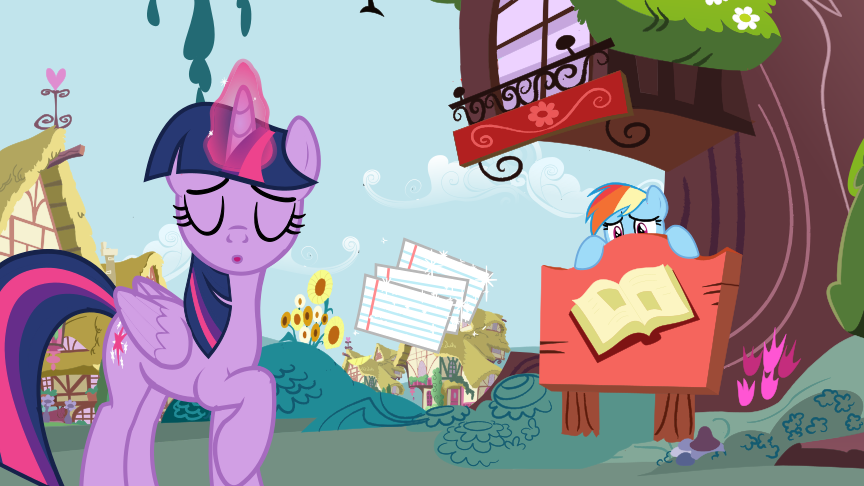

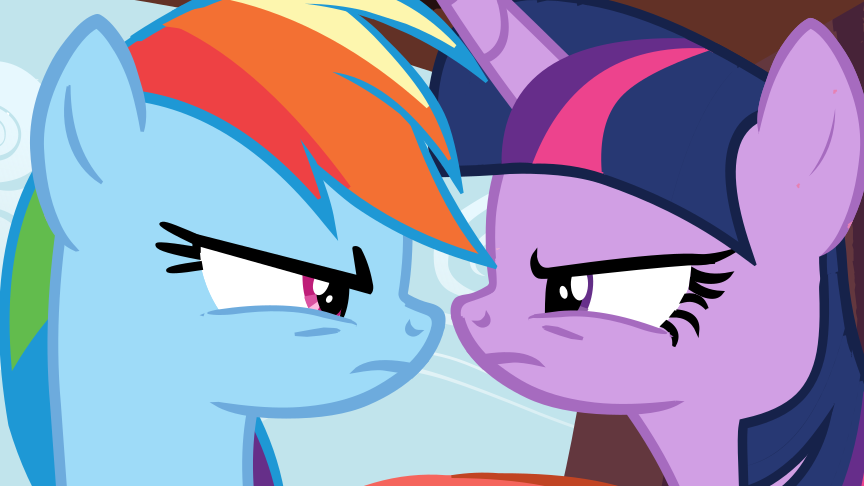

In [4]:
# You can load the frames using the xflsvg.rendertrace package
from xflsvg import rendertrace
trace = rendertrace.RenderTraceReader('/tmp/sample-trace')

# And render a frame using xflsvg.pngrenderer
from xflsvg import pngrenderer
renderer = pngrenderer.PngRenderer()

# By default, it will render within a bounding box unless you set the camera
renderer.set_camera(*trace.get_camera())

master_timeline = trace.get_timeline()
all_frames = list(master_timeline) # the timeline is iterable

with renderer:
    # Just render two frames for demonstration purposes
    all_frames[0].render()
    all_frames[300].render()

pngs = renderer.compile()

# Let's see what it created...

from IPython.display import Image, display
from io import StringIO
def display_png(png):
    # helper function since this is tedious
    display(Image(png))


display_png(pngs[0])
display_png(pngs[1])

# What cute mares!

In [5]:
# There are three things you can mess with: shape data, frame structure, and timeline
# structure. Let's start with shape data.

# We'll steal a shape from shapes.json as a shortcut.
import json
with open('/tmp/sample-trace/shapes.json') as inp:
    shapes = json.load(inp)

# Let's pick a simple shape so it's easy to see what's going on.
for candidate in shapes.values():
    if len(candidate['shape']) != 4:
        continue
    
    
    # We want one that's filled in too, not just a border. It isn't necessary for
    # anything, it's just that filled in things seem more shapey.
    if len(candidate['fill_styles']) > 2:
        simple_shape = candidate
        break

print('=== Shape data ===')
print(json.dumps(simple_shape, indent=4)[:800], end='\n...\n')
print('=== Keys ===')
print(simple_shape.keys())
print('=== fill_styles (this is highly semantic; you can interpret the values here based on the svg spec) ===')
print(simple_shape['fill_styles'])
print('=== stroke_styles (this is also highly semantic; again, the svg spec explains what these all mean) ===')
print(simple_shape['stroke_styles'])
print('=== single item of the "shape" array (will probably be renamed to "graph") ===')
print(simple_shape['shape'][0].keys())
print('=== example point on the path ("point" refers to x,y coordinate, "control" specifies what kind of point it is (see bezier curves) ===')
print(simple_shape['shape'][0]['path'][0])

=== Shape data ===
{
    "mask": false,
    "fill_styles": {
        "1": {
            "stroke": "#1E98D5",
            "fill": "#1E98D5"
        },
        "2": {
            "stroke": "#62BC4D",
            "fill": "#62BC4D"
        },
        "3": {
            "stroke": "#662F89",
            "fill": "#662F89"
        }
    },
    "stroke_styles": {},
    "shape": [
        {
            "path": [
                {
                    "point": [
                        -1.85,
                        -0.175
                    ],
                    "control": false
                },
                {
                    "point": [
                        -3.2447265625,
                        -1.819140625
                    ],
                    "control": true
                },
                {
  
...
=== Keys ===
dict_keys(['mask', 'fill_styles', 'stroke_styles', 'shape'])
=== fill_styles (this is highly semantic; you can interpret the values here based on the svg spec) ===

converting to png: 1it [00:00, 259.66it/s]


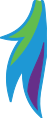

converting to png: 1it [00:00, 171.63it/s]


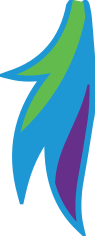

In [6]:
# In any case, let's render just this shape.
from xflsvg.xflsvg import ShapeFrame

def display_shape(shape, **kwargs):
    # You can pass either XFL DOMShapes here or these shape dictionaries
    frame = ShapeFrame(shape, '.trace')

    # You can render it like any other frame.
    renderer = pngrenderer.PngRenderer()
    with renderer:
        frame.render()
    png = renderer.compile(**kwargs)[0]

    display_png(png)

# Let's see what we got.
display_shape(simple_shape)

# It's too small...
display_shape(simple_shape, scale=2)

# That's better.
# I don't know what it is, but it looks soft!

{'1': {'stroke': '#1E98D5', 'fill': '#1E98D5'}, '2': {'stroke': '#62BC4D', 'fill': '#62BC4D'}, '3': {'stroke': '#662F89', 'fill': '#662F89'}}


converting to png: 1it [00:00, 238.41it/s]


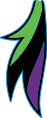

converting to png: 1it [00:00, 283.42it/s]


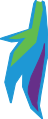

In [7]:
# Let's manipulate the shape.

# First, let's make the strokes all black.
# Make a a copy first so it isn't messing with the original...
import copy
modded_shape = copy.deepcopy(simple_shape)

# Let's mess with a fill color.
print(modded_shape['fill_styles'])
modded_shape['fill_styles']['1']['fill'] = '#000000'
display_shape(modded_shape)
# You can update fill and stroke items arbitrarily, but you should only remove items
# if they're not referenced by any ['shape'] item.

# Let's see what the 'control' flag does.
modded_shape = copy.deepcopy(simple_shape)
for sh in modded_shape['shape']:
    for pt in sh['path']:
        pt['control'] = False
display_shape(modded_shape)
# Looks like someone needs to learn to draw better.

# Note that the first and last points in a path cannot be control points, and you
# cannot have two consecutive control points. If a ["shape"][x] item has a fill,
# the point lists should form a bunch of cycles. a->b->c, c->d->e, e->a is a valid
# set of point lists with a fill. a->b->c, c->d->c is not since there's no cycle
# containing a->b->c.

In [8]:
# Okay, now let's mess with the frame structure.
# Let's get some frame data first.

# Once we get beyond shapes, rendering things requires properly connecting them down
# to shapes. We could do that manually by reading frames.json and shapes.json, but it's
# very tedious. It's easier to just use rendertrace.
trace = rendertrace.RenderTraceReader('/tmp/sample-trace/')

# The frames we get from this are actually indexes into a giant DAG.
frames = list(trace.get_timeline())
some_dag_ptr = frames[0]
# You can get the id for a frame like with .identifier
print(some_dag_ptr.identifier)

# And we'll get to this later, but you can check if there are any labels associated
# with the frame / dag_pointer using trace.labels
print(trace.labels.get(some_dag_ptr.identifier, "no data"))

# The 'timeline' tells you which frame table this frame belongs to. The 'frame' tells
# you which vertical slice (timestamp) this frame refers to. Some frames also have a
# 'layer' value, which tells you which horizontal slice the frame belongs to. Most
# frames aren't going to have labels since they're only used as parts of other (often
# multiple) frames.

# If there's a 'source', that tells you which file this frame originated from. If
# are 'width' and 'height' values, those correspond to the camera used to render
# the frame.

5780
{'timeline': 'document://MLP422_103.xfl/Scene 1', 'source': 'MLP422_103.xfl', 'frame': 0, 'width': 864.0, 'height': 486.0}


converting to png: 1it [00:00,  3.03it/s]


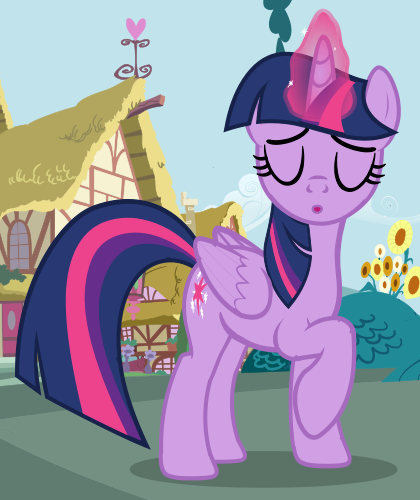

8932
5791
5781


converting to png: 1it [00:00,  3.11it/s]


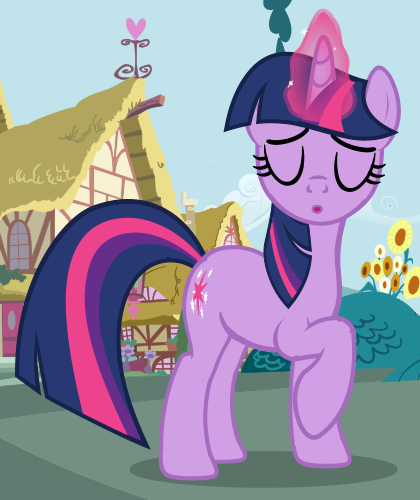

In [9]:
# Let's remove any layer with 'wing' in the name

# First, let's see what we pulled.
def display_frame(frame, camera=None, **kwargs):    
    renderer = pngrenderer.PngRenderer()
    if camera:
        renderer.set_camera(*camera)
    with renderer:
        frame.render()
    png = renderer.compile(**kwargs)[0]
    display_png(png)

display_frame(some_dag_ptr, camera=[-80, 50, 420, 500])

# We're going to end up deleting a layer by removing its child frames in the dag.
# It's probably better to have all of that layer frame's parents disown it, but
# I don't have an API for getting all parents of a frame at the moment.

# By the way, you can navigate the dag by recursively checking .children on a frame.
for child in some_dag_ptr.children:
    print(child.identifier)

# Now let's delete the wing layers.
for frame_id, label in trace.labels.items():
    if 'layer' not in label:
        continue
    if not 'wing' in label['layer'].lower():
        continue
    
    # Inspecting frame_cache directly is a hack... I'll add a better way to do this
    # later.
    # Note: We need to use int(frame_id) because frame identifiers are integer, but
    # json dict keys can only be strings. Again, I'll find a cleaner interface for
    # this later.
    trace.frame_cache[int(frame_id)].children.clear()

# And let's see the result.
display_frame(some_dag_ptr, camera=[-80, 50, 420, 500])

# Much better!

# By the way, we modified the dag without making a copy, so you'll need to reload it
# if you want the unmodified version again.

In [10]:
# I'll write up a guide on manipulating labels later.
# There are lots of bugs right now in the renderer, and I haven't been able to do a
# thorough test of all the packages since my last big refactor. Expect issues. I'll
# fix them after the anni.

In [11]:
# Side note: I highly recommend using the SvgRenderer rather than the PngRenderer
# while developing. It's MUCH faster. Here's the relevant code. I'm only using
# PngRenderer because the resulting images are a lot smaller, and github doesn't like
# my giant svgs.

from xflsvg import svgrenderer

def display_shape(shape, **kwargs):
    # You can pass either XFL DOMShapes here or these shape dictionaries.
    # If you pass a domshape, use '.domshape'. If you use a dictionary, use '.trace'.
    frame = ShapeFrame(shape, '.trace')

    renderer = svgrenderer.SvgRenderer()
    with renderer:
        frame.render()
    svg = renderer.compile(**kwargs)[0]

    display_svg(svg)


def display_frame(frame, camera=None, **kwargs):    
    renderer = svgrenderer.SvgRenderer()
    if camera:
        renderer.set_camera(*camera)
    with renderer:
        frame.render()
    svg = renderer.compile(**kwargs)[0]
    display_svg(svg)

# Some other useful packages not used here:
# ... from xflsvg import xflsvg: used for parsing xfl files
# ... from xflsvg import samplerenderer: used for reading & writing asset label files
# ... from xflsvg import gifrenderer: used for converting svgs to pngs or gifs